In [1]:
!pip install ujson 
!pip install seaborn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/f8/8c/5274ba7b4df814c87a8840a58e2b1dae6a489f49c3b0fad2d15f1e41d47b/ujson-5.3.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/10/5b/0479d7d845b5ba410ca702ffcd7f2cd95a14a4dfff1fde2637802b258b9b/seaborn-0.11.2-py3-none-any.whl (292 kB)
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
import sys 
sys.path.append('../')

In [18]:
import os
from pathlib import Path
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [68]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load train and validation data 

In [5]:
time_start = time.time()

data_args = {'stage': 'train',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], # ['drumstick'],#'sofa'], #, 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 0}
train_data = dataset_lvis.LVISData(**data_args)

print(f'Time taken to initialize train set: {time.time()-time_start}')

classes : {1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}
loaded 618 positive set images
loaded 0 negative set images
loaded 25 non-exhaustive set images
Loaded 593 images!
class 1 has 71 positive and 0 negative images
class 2 has 9 positive and 0 negative images
class 3 has 233 positive and 0 negative images
class 4 has 199 positive and 0 negative images
class 5 has 8 positive and 0 negative images
class 6 has 73 positive and 0 negative images
995 annotations found!
stage:  train
classes:  {'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_train.json
imgs_dir:  ../Datasets/coco/images/train2017
Time taken to initialize train set: 30.310505867004395


### Split train set into custom train val set

Validation set reserved for testing

Check that we don't have too many of the rare cases in validation set - if so then there won't be much data to actually train on.

In [10]:
# what images have what classes?
g_cpu = torch.Generator()
g_cpu.manual_seed(2)

#Split dataset to test and train
indices = torch.randperm(len(train_data), generator=g_cpu).tolist()


dataset_train = torch.utils.data.Subset(train_data, indices[:550])
dataset_val = torch.utils.data.Subset(train_data, indices[550:])


class_counts = dict(zip(range(1,7), [0]*6))
for _, _, y in dataset_val:
    for label in y['labels']:
        class_counts[label.item()] += 1
            
class_counts

{1: 6, 2: 1, 3: 26, 4: 14, 5: 0, 6: 12}

## Prepare test set

The LVIS validation set is reserved for our test set

In [69]:
time_start = time.time() 
data_args = {'stage': 'val',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chessboard'], #['drumstick'],#'sofa'], #, 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640,
            'max_negative' : 200}   # note that we include negative sets for the testing
test_data = dataset_lvis.LVISData(**data_args)
print(f'Time taken to initialize val set: {time.time()-time_start}')

classes : {1: 'cappuccino', 2: 'chessboard', 3: 'coffee_maker', 4: 'cowboy_hat', 5: 'drumstick', 6: 'monkey'}
loaded 119 positive set images
loaded 1003 negative set images
loaded 2 non-exhaustive set images
Loaded 1116 images!
class 1 has 17 positive and 189 negative images
class 2 has 1 positive and 186 negative images
class 3 has 46 positive and 172 negative images
class 4 has 39 positive and 188 negative images
class 5 has 2 positive and 111 negative images
class 6 has 12 positive and 182 negative images
166 annotations found!
stage:  val
classes:  {'cappuccino': 206, 'chessboard': 240, 'coffee_maker': 284, 'cowboy_hat': 319, 'drumstick': 400, 'monkey': 699}
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  ../Datasets/coco/images/train2017
Time taken to initialize val set: 12.648752450942993


# Fine-tuning the model

Here we set `pretrained = False` for the FPN: FPN is pre-trained on coco dataset so we'll try to retrain from scratch. We keep the backbone ResNet50 pretrained on ImageNet.

In [9]:
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

# Set up DataLoaders

In [11]:

train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=10, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

val_loader = torch.utils.data.DataLoader(
 dataset_val, batch_size=10, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


# Initialize Model + Model params

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 7 classes - background and 6 specified objects
num_classes = 7

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train Model

In [13]:
num_epochs = 50
time_start = time.time() 


train_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
val_loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])

loss_types = ['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss']


for epoch in range(num_epochs):
    model.train()
    
    train_loss = dict.fromkeys(loss_types, 0) 
    val_loss = dict.fromkeys(loss_types, 0) 
    
    """
    Train 
    """
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        losses = sum(loss for loss in loss_dict.values())
        
        #save losses
        for key in loss_types:
            if key != 'total_loss':
                train_loss[key] += loss_dict[key].item()
            else: 
                train_loss['total_loss'] += losses.item()
                

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [train_loss['loss_classifier']/(batch_num+1)],
          'loss_box_reg' : [train_loss['loss_box_reg']/(batch_num+1)],
           'loss_mask': [train_loss['loss_mask']/(batch_num+1)],
           'loss_objectness': [train_loss['loss_objectness']/(batch_num+1)],
           'loss_rpn_box_reg': [train_loss['loss_rpn_box_reg']/(batch_num+1)],
            'total_loss': [train_loss['total_loss']/(batch_num+1)] 
          })     

    train_loss_df = pd.concat([train_loss_df, row], ignore_index = True, axis = 0)
    
    print(f"Training loss after {epoch} epochs: {train_loss['total_loss']}")

    
    """
    Validation
    """
    with torch.no_grad():
        for batch_num, (idx, X, y) in enumerate(val_loader):
            X = X.to(device)
            y = [{k: v.to(device) for k, v in t.items()} for t in y]

            loss_dict = model(X, y) 
            
            losses_val = sum(loss for loss in loss_dict.values())
            
            #save losses
            for key in loss_types:
                if key != 'total_loss':
                    val_loss[key] += loss_dict[key].item()
                else: 
                    val_loss['total_loss'] += losses_val.item()
                    
        row = pd.DataFrame({'epoch': [epoch],
                          'loss_classifier': [val_loss['loss_classifier']/(batch_num+1)],
                          'loss_box_reg' : [val_loss['loss_box_reg']/(batch_num+1)],
                           'loss_mask': [val_loss['loss_mask']/(batch_num+1)],
                           'loss_objectness': [val_loss['loss_objectness']/(batch_num+1)],
                           'loss_rpn_box_reg': [val_loss['loss_rpn_box_reg']/(batch_num+1)],
                            'total_loss': [val_loss['total_loss']/(batch_num+1)] 
                          })
        val_loss_df = pd.concat([val_loss_df, row], ignore_index = True, axis = 0)

    print(f"Validation loss after {epoch} epochs: {val_loss['total_loss']}") 
    print(f'Time elapsed for {epoch} epochs: {time.time()-time_start}') 

      
    """
    Save checkpoints and losses every 5 epoch
    """
    if epoch%5 == 0: 
        checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch,
                        "ds_args" : data_args
                        }
        fname = "model_" + str(epoch) + "_epochs.pth"
        helper.save_checkpoint(checkpoint, fname)
        print(f'Time elapsed after {epoch} epochs: {time.time()-time_start}')  
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))

    
    
    #for final epoch 
    if epoch == num_epochs-1: 
        helper.save_model(model.state_dict(), "model.pth")
        val_loss_df.to_csv(Path.cwd().parent.joinpath("val_loss.csv"))
        train_loss_df.to_csv(Path.cwd().parent.joinpath("train_loss.csv"))
    
    
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1153.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training loss after 0 epochs: 70.11650776863098
Validation loss after 0 epochs: 4.14311671257019
Time elapsed for 0 epochs: 90.64811968803406
Saved checkpoint model_0_epochs.pth!
Time elapsed after 0 epochs: 92.47265195846558
Training loss after 1 epochs: 49.90538018941879
Validation loss after 1 epochs: 3.9391698241233826
Time elapsed for 1 epochs: 182.1252818107605
Training loss after 2 epochs: 46.451831340789795
Validation loss after 2 epochs: 3.557008147239685
Time elapsed for 2 epochs: 271.9290690422058
Training loss after 3 epochs: 42.485505640506744
Validation loss after 3 epochs: 3.2987363040447235
Time elapsed for 3 epochs: 361.43655371665955
Training loss after 4 epochs: 39.786172449588776
Validation loss after 4 epochs: 3.681826889514923
Time elapsed for 4 epochs: 450.64519739151
Training loss after 5 epochs: 37.45835664868355
Validation loss after 5 epochs: 3.059147298336029
Time elapsed for 5 epochs: 539.6711666584015
Saved checkpoint model_5_epochs.pth!
Time elapsed after

# Plot loss 

,train_loss,val_loss
0,1.274846,0.828623
1,0.907371,0.787834
2,0.844579,0.711402
3,0.772464,0.659747
4,0.723385,0.736365
5,0.681061,0.611829
6,0.625037,0.561227
7,0.581755,0.568512
8,0.559229,0.528955
9,0.522673,0.637493


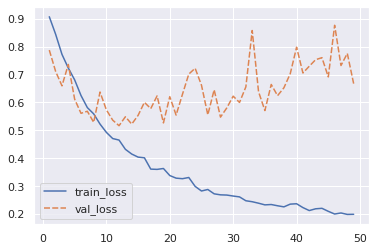

In [15]:
new_df = pd.DataFrame() 
#new_df['epoch'] = train_loss_df['epoch'] 
new_df['train_loss'] = train_loss_df['total_loss'] 
new_df['val_loss'] = val_loss_df['total_loss'] 

sns.lineplot(data = new_df[1:])
new_df


In [16]:
train_loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.262297,0.033436,0.698337,0.241498,0.039278,1.274846
1,1,0.120505,0.064663,0.578448,0.110058,0.033697,0.907371
2,2,0.14373,0.094585,0.486173,0.087607,0.032483,0.844579
3,3,0.140447,0.101061,0.424709,0.074406,0.031841,0.772464
4,4,0.131518,0.101512,0.396109,0.065008,0.029238,0.723385
5,5,0.120763,0.095647,0.375343,0.062205,0.027103,0.681061
6,6,0.118626,0.105295,0.327996,0.048055,0.025066,0.625037
7,7,0.111559,0.107615,0.301013,0.03995,0.021618,0.581755
8,8,0.10826,0.110034,0.284868,0.034617,0.02145,0.559229
9,9,0.102292,0.109855,0.264487,0.026617,0.019422,0.522673


In [17]:
val_loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.085024,0.039443,0.611934,0.078627,0.013595,0.828623
1,1,0.136172,0.075162,0.504973,0.059921,0.011606,0.787834
2,2,0.147855,0.097606,0.402613,0.053591,0.009737,0.711402
3,3,0.134884,0.099948,0.360933,0.048822,0.015159,0.659747
4,4,0.145978,0.095541,0.436849,0.045333,0.012665,0.736365
5,5,0.122495,0.101614,0.333561,0.045135,0.009025,0.611829
6,6,0.111461,0.095663,0.292545,0.051784,0.009773,0.561227
7,7,0.103234,0.094178,0.324986,0.037873,0.008242,0.568512
8,8,0.095846,0.089874,0.296075,0.038046,0.009115,0.528955
9,9,0.107208,0.08819,0.363999,0.068977,0.009119,0.637493


## Run the testing

In [51]:
importlib.reload(metrics)
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [56]:
test_loader = torch.utils.data.DataLoader(
 test_data, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())

If testing at different time from training, then load checkpoints.

Or load checkpoints from earlier stopping point

In [57]:
cp_path = Path('../model_checkpoints/model_10_epochs.pth')
helper.load_checkpoint(cp_path, model, optimizer)


Loaded checkpoint ../model_checkpoints/model_10_epochs.pth!


In [59]:
%%time

pred_boxes = []
gt = []
for idx, X, y in test_loader:
    model.eval()
    y_pred = model(X.to(device))
    # keep running list of predictions and ground truths
    pred_boxes, gt = metrics.store_preds(idx, y, y_pred,
                                     pred_boxes, gt)

mAP_list = []
thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
for iou_thresh in thresholds:
    mAP_list.append(metrics.calculate_ap(pred_boxes, gt, 
                               iou_threshold=iou_thresh,
                               class_datasets = test_data.class_datasets))

print('\n\n\n--------------\n\n')
for i in range(len(thresholds)):
    print('mAP for iou_threshold of {}: {:.3f}'.format(thresholds[i], mAP_list[i][0]))



CPU times: user 3min 52s, sys: 8min 5s, total: 11min 58s
Wall time: 1min 44s


### Print out per category mAP

Table below shows the categories we have in rows, and different IoU thresholds in columns.

We also print the number of images in the test set containing each category. You can see that the model doesn't have much chance to prove itself on chessboard or drumstick categories!

In [75]:
df = pd.DataFrame(index = list(range(1, 7)), columns = ['positives'] + thresholds)

df['positives'] = [len(c['positive']) for c in test_data.class_datasets.values()]

for i in range(len(thresholds)):
    data = [v.item() for v in mAP_list[i][1].values()]
    df[thresholds[i]] = data

df.rename(index=test_data.idx_to_classname, inplace=True)
df.round(4)

,positives,0.5,0.7,0.8,0.9,0.95
cappuccino,17,0.2398,0.0889,0.0476,0.0000,0.0000
chessboard,1,0.0000,0.0000,0.0000,0.0000,0.0000
coffee_maker,46,0.6546,0.4761,0.1520,0.0041,0.0004
cowboy_hat,39,0.3491,0.1301,0.0094,0.0001,0.0000
drumstick,2,0.0000,0.0000,0.0000,0.0000,0.0000
monkey,12,0.0073,0.0000,0.0000,0.0000,0.0000
